# Building convolutional neural network in Numpy
---

***Author: Piotr Skalski***

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from mlxtend.data import loadlocal_mnist
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Settings

In [2]:
# number of samples in the data set
N_SAMPLES = 1000
# ratio between training and test sets
TEST_SIZE = 0.1
# size of the photo
PHOTO_SIZE = 28
# number of pixels in the photo
PIXEL_NUMBER = PHOTO_SIZE * PHOTO_SIZE
# neural network architecture
NN_ARCHITECTURE = [
    {"input_dim": PIXEL_NUMBER, "output_dim": 1000, "activation": "relu"},
    {"input_dim": 1000, "output_dim": 1000, "activation": "relu"},
    {"input_dim": 1000, "output_dim": 500, "activation": "relu"},
    {"input_dim": 500, "output_dim": 500, "activation": "relu"},
    {"input_dim": 500, "output_dim": 10, "activation": "softmax"},
]

## Data preparation

### Auxiliary function downloading the dataset

In [3]:
def download_mnist_dataset():
    # The MNIST data set is available at http://yann.lecun.com, let's use curl to download it
    if not os.path.exists("train-images-idx3-ubyte"):
        !curl -O http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
        !curl -O http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
        !curl -O http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
        !curl -O http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
        !gunzip t*-ubyte.gz
        
    # Let's use loadlocal_mnist available in mlxtend.data to get data in numpy array form.
    X1, y1 = loadlocal_mnist(
        images_path="train-images-idx3-ubyte", 
        labels_path="train-labels-idx1-ubyte")

    X2, y2 = loadlocal_mnist(
        images_path="t10k-images-idx3-ubyte", 
        labels_path="t10k-labels-idx1-ubyte")
    
    # We normalize the brightness values for pixels
    X1 = X1.reshape(X1.shape[0], -1) / 255
    X2 = X2.reshape(X2.shape[0], -1) /255

    # Combine downloaded data bundles
    X = np.concatenate([X1, X2])
    y = np.concatenate([y1, y2])
    
    return X, y

### Auxiliary function for labels one hot encoding

In [4]:
def one_hot_encoding(y):
    n_values = np.max(y) + 1
    return np.eye(n_values)[y]

### Auxiliary function for data preparation

In [5]:
def prepare_data(split_percentage):
    # Download data
    X, y = download_mnist_dataset()
    # One hot encode labels
    y = one_hot_encoding(y)
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_percentage, random_state=42)
    return np.transpose(X_train), np.transpose(X_test), np.transpose(y_train), np.transpose(y_test)

In [6]:
X_train, X_test, y_train, y_test = prepare_data(TEST_SIZE)

### Auxiliary function to display the selected data set element

In [7]:
def plot_digit(X, y, idx):
    img = X[:, idx].reshape(28,28)
    plt.imshow(img, cmap='Greys',  interpolation='nearest')
    plt.title('true label: %d' % np.where(y[:, idx] != 0)[0][0])
    plt.show()

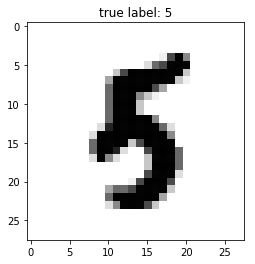

In [8]:
plot_digit(X_train, y_train, 3)

### Adaptation of the existing implementation to support multiple classes

In [9]:
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def relu(Z):
    return np.maximum(0,Z)

def softmax(Z):
    # Column wise softmax
    e_Z = np.exp(Z - np.max(Z))
    return e_Z / e_Z.sum(axis = 0)

def sigmoid_backward(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1 - sig)

def relu_backward(dA, Z):
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0
    return dZ

In [10]:
scores2D = np.array([[1, 2, 3, 6],
                     [2, 4, 5, 6],
                     [3, 8, 7, 6]])

In [11]:
softmax(scores2D)

array([[0.09003057, 0.00242826, 0.01587624, 0.33333333],
       [0.24472847, 0.01794253, 0.11731043, 0.33333333],
       [0.66524096, 0.97962921, 0.86681333, 0.33333333]])

In [12]:
def init_layers(nn_architecture, seed = 99):
    np.random.seed(seed)
    number_of_layers = len(nn_architecture)
    params_values = {}
    
    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        
        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]
        
        params_values['W' + str(layer_idx)] = np.random.randn(
            layer_output_size, layer_input_size) * 0.1
        params_values['b' + str(layer_idx)] = np.random.randn(
            layer_output_size, 1) * 0.1
        
    return params_values

In [13]:
def single_layer_forward_propagation(A_prev, W_curr, b_curr, activation="relu"):
    Z_curr = np.dot(W_curr, A_prev) + b_curr
    
    if activation is "relu":
        activation_func = relu
    elif activation is "sigmoid":
        activation_func = sigmoid
    elif activation is "softmax":
        activation_func = softmax
    else:
        raise Exception('Non-supported activation function')
        
    return activation_func(Z_curr), Z_curr

In [14]:
def full_forward_propagation(X, params_values, nn_architecture):
    memory = {}
    A_curr = X
    
    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        A_prev = A_curr
        
        activ_function_curr = layer["activation"]
        W_curr = params_values["W" + str(layer_idx)]
        b_curr = params_values["b" + str(layer_idx)]
        A_curr, Z_curr = single_layer_forward_propagation(A_prev, W_curr, b_curr, activ_function_curr)
        
        memory["A" + str(idx)] = A_prev
        memory["Z" + str(layer_idx)] = Z_curr
       
    return A_curr, memory

In [15]:
# def get_cost_value(Y_hat, Y, eps = 0.001):
#     m = Y_hat.shape[1]
#     cost = -1 / m * (np.dot(Y, np.log(Y_hat + eps).T) + np.dot(1 - Y, np.log(1 - Y_hat  + eps).T))
#     return np.squeeze(cost)

In [16]:
def multi_class_cross_entropy_loss(Y_hat, Y):
    m = Y_hat.shape[1]
    loss = - np.sum(Y * np.log(Y_hat)) / m
    return loss

In [17]:
# def convert_prob_into_class(probs):
#     probs_ = np.copy(probs)
#     probs_[probs_ > 0.5] = 1
#     probs_[probs_ <= 0.5] = 0
#     return probs_


# def get_accuracy_value(Y_hat, Y):
#     Y_hat_ = convert_prob_into_class(Y_hat)
#     return (Y_hat_ == Y).all(axis=0).mean()

In [18]:
def multi_class_accuracy(Y_hat, Y):
    n_values = Y_hat.shape[0]
    values = Y_hat.argmax(axis=0)
    Y_hat_one_hot = np.eye(n_values)[values].T
    return (Y_hat_one_hot == Y).all(axis=0).mean()

In [19]:
def single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation="relu"):
    m = A_prev.shape[1]
    
    if activation is "relu":
        backward_activation_func = relu_backward
    elif activation is "sigmoid":
        backward_activation_func = sigmoid_backward
    elif activation is "softmax":
        # TEST OF COURSERA SOLUTION
        backward_activation_func = lambda dA_curr, Z_curr: dA_curr
    else:
        raise Exception('Non-supported activation function')
    
    dZ_curr = backward_activation_func(dA_curr, Z_curr)
    dW_curr = np.dot(dZ_curr, A_prev.T) / m
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
    dA_prev = np.dot(W_curr.T, dZ_curr)

    return dA_prev, dW_curr, db_curr

In [20]:
def full_backward_propagation(Y_hat, Y, memory, params_values, nn_architecture, eps = 0.000000000001):
    grads_values = {}
    m = Y.shape[1]
    Y = Y.reshape(Y_hat.shape)
    
#     dA_prev = - (np.divide(Y, Y_hat + eps) - np.divide(1 - Y, 1 - Y_hat + eps))
    # TEST OF COURSERA SOLUTION
    dA_prev = Y_hat - Y
    
    for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
        layer_idx_curr = layer_idx_prev + 1
        activ_function_curr = layer["activation"]
        
        dA_curr = dA_prev
        
        A_prev = memory["A" + str(layer_idx_prev)]
        Z_curr = memory["Z" + str(layer_idx_curr)]
        
        W_curr = params_values["W" + str(layer_idx_curr)]
        b_curr = params_values["b" + str(layer_idx_curr)]
        
        dA_prev, dW_curr, db_curr = single_layer_backward_propagation(
            dA_curr, W_curr, b_curr, Z_curr, A_prev, activ_function_curr)
        
        grads_values["dW" + str(layer_idx_curr)] = dW_curr
        grads_values["db" + str(layer_idx_curr)] = db_curr
    
    return grads_values

In [21]:
def update(params_values, grads_values, nn_architecture, learning_rate):

    for layer_idx, layer in enumerate(nn_architecture, 1):
        params_values["W" + str(layer_idx)] -= learning_rate * grads_values["dW" + str(layer_idx)]        
        params_values["b" + str(layer_idx)] -= learning_rate * grads_values["db" + str(layer_idx)]

    return params_values

In [22]:
def train(X, Y, nn_architecture, epochs, learning_rate, verbose=False, callback=None):
    params_values = init_layers(nn_architecture, 2)
    cost_history = []
    accuracy_history = []
    
    for i in range(epochs):
        Y_hat, cashe = full_forward_propagation(X, params_values, nn_architecture)
        
#         print(Y_hat.shape)
#         print(Y.shape)
        
        cost = multi_class_cross_entropy_loss(Y_hat, Y)
        cost_history.append(cost)
        
#         print(cost)
        
        accuracy = multi_class_accuracy(Y_hat, Y)
        accuracy_history.append(accuracy)
        
#         print(accuracy)
        
        grads_values = full_backward_propagation(Y_hat, Y, cashe, params_values, nn_architecture)
        params_values = update(params_values, grads_values, nn_architecture, learning_rate)
        
        if(i % 5 == 0):
            if(verbose):
                print("Iteration: {:05} - cost: {:.5f} - accuracy: {:.5f}".format(i, cost, accuracy))
            if(callback is not None):
                callback(i, params_values)
            
    return params_values, cost_history, accuracy_history

In [23]:
SUBSET_SIZE = 10000
X_train = X_train[:,:SUBSET_SIZE]
y_train = y_train[:,:SUBSET_SIZE]

In [24]:
params_values, cost_history, accuracy_history = train(X_train, y_train, NN_ARCHITECTURE, 100, 0.01, verbose=True)

Iteration: 00000 - cost: 18.05769 - accuracy: 0.09350
Iteration: 00005 - cost: 6.55857 - accuracy: 0.34620
Iteration: 00010 - cost: 1.29068 - accuracy: 0.67030
Iteration: 00015 - cost: 1.01207 - accuracy: 0.73030
Iteration: 00020 - cost: 0.85441 - accuracy: 0.76560
Iteration: 00025 - cost: 0.75597 - accuracy: 0.78840
Iteration: 00030 - cost: 0.68273 - accuracy: 0.80950
Iteration: 00035 - cost: 0.62498 - accuracy: 0.82370
Iteration: 00040 - cost: 0.57798 - accuracy: 0.83580
Iteration: 00045 - cost: 0.53846 - accuracy: 0.84670
Iteration: 00050 - cost: 0.50445 - accuracy: 0.85660
Iteration: 00055 - cost: 0.47479 - accuracy: 0.86430
Iteration: 00060 - cost: 0.44866 - accuracy: 0.87120
Iteration: 00065 - cost: 0.42536 - accuracy: 0.87710
Iteration: 00070 - cost: 0.40445 - accuracy: 0.88430
Iteration: 00075 - cost: 0.38556 - accuracy: 0.88860
Iteration: 00080 - cost: 0.36836 - accuracy: 0.89520
Iteration: 00085 - cost: 0.35262 - accuracy: 0.89900
Iteration: 00090 - cost: 0.33812 - accuracy: 

In [26]:
y_test_hat, _ = full_forward_propagation(X_test, params_values, NN_ARCHITECTURE)
accuracy = multi_class_accuracy(y_test_hat, y_test)
print(accuracy)

0.8602857142857143


## Resources

https://gombru.github.io/2018/05/23/cross_entropy_loss/
http://wiki.fast.ai/index.php/Log_Loss
http://cs231n.github.io/neural-networks-case-study/
http://saitcelebi.com/tut/output/part2.html
https://deepnotes.io/softmax-crossentropy
https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/